In [1]:
import streamlit as st
from utils import filtrar
from data import load_data
import pandas as pd
import numpy as np
import requests
import soft
import tech
import tech_
from pprint import pprint
import plotly.express as px


tables_id = {"Trabajadores"               : "tblNBHV9KDGDQNs8y",
             "Roles"                      : "tblk2itGEWE7ePo73",
             "Tecnologías"                : "tblXhF1lZUBKiNixP",
             "Competencias técnicas"      : "tblLUDGmhm7otZhGp",
             "Competencias blandas"       : "tblvuUUjjnUvdS1z1",
             "Certificaciones"            : "tblUforpTYin3pEZs",
             "Formulario certificaciones" : "tblERjkIA64JGPgNW",
             "Pruebas técnicas"           : "tblGy8pLPexkcpJcq",
             "Verticales"                 : "tblDZzmvFmWfMbmx5",
             "Assessment MAPFRE"          : "tbl7EYNl618IhKAse",
             "Data blandas"               : "tblImXJh9fSnqrW8B",
             "Data Competencias técnicas" : "tbl1kSY13iQhxi1O3",
             "Data Tecnologías"           : "tblca2y3nQTUPrbfx"}

def extract_airtable(app: str, tbl: str, token: str) -> pd.DataFrame:
    url = f"https://api.airtable.com/v0/{app}/{tbl}"

    response = requests.get(url, headers={"Authorization" : f"Bearer {"patAavpcVDkODOexK.4077431682eb04c6617a62752b02d81efc3031128fc8294b2328d4e18d5233bb"}"})
    data = response.json()
    records = data["records"]

    while "offset" in data.keys():
        r = requests.get(url, headers={"Authorization" : f"Bearer {token}"}, params={"offset" : data["offset"]})
        data = r.json()
        records.extend(data["records"])

    return pd.json_normalize(records)

def extract_all_airtable(tables_id: dict) -> dict:

    AIRTABLE_API_KEY = "patAavpcVDkODOexK.4077431682eb04c6617a62752b02d81efc3031128fc8294b2328d4e18d5233bb"

    app_id = "appACxf1z2b7fsR44"

    df_dicts = dict()
    for k, v in tables_id.items():
        
        df_bucle = extract_airtable(app = app_id, tbl = v, token = AIRTABLE_API_KEY).drop(["createdTime"], axis = 1)

        df_bucle.columns = [col.replace("fields.", "") for col in df_bucle.columns]

        df_dicts[k] = df_bucle
    return df_dicts

df_dicts = extract_all_airtable(tables_id = tables_id)

# Primera Gráfica

In [ ]:
def primera_grafica(df_dicts):
    # Relación "Certificaciones (from Rol que le corresponde)" vs ""Certificaciones faltantes para el rol (INFORME)""
    
    df = df_dicts["Trabajadores"][["Nombre", "Certificaciones", "Certificaciones (from Rol que le corresponde)", "Certificaciones faltantes para el rol (INFORME)", "Nueva vertical"]]
    
    for col in df.columns:
    
        df[col] = df[col].apply(lambda x : list(set(x)) if type(x) == list else x)
    
    df["Certificaciones Totales"] = df["Certificaciones"].apply(lambda x : len(x) if type(x) == list else 0)
    
    df["Certificaciones Totales por Rol"] = df["Certificaciones (from Rol que le corresponde)"].apply(lambda x : len(x) if type(x) == list else 0)
    
    df["Certificaciones Faltantes"] = df["Certificaciones faltantes para el rol (INFORME)"].apply(lambda x : len(x) if type(x) == list else 0)
    
    df["Porcentaje Certificaciones Faltantes"] = np.round(df["Certificaciones Faltantes"] / df["Certificaciones Totales por Rol"] * 100, 2)
    
    df = pd.merge(left = df.explode("Nueva vertical"), right = df_dicts["Verticales"][["id", "Vertical"]], left_on = "Nueva vertical", right_on = "id", how = "left")
    
    df_resultado = df.groupby(by = ["Vertical"], as_index = False).agg({"Porcentaje Certificaciones Faltantes" : "mean"})
    
    df_resultado["Porcentaje Certificaciones Faltantes"] = df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
    df_resultado["Porcentaje Certificaciones Realizadas"] = 100 - df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
    
    df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]] = df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]].round(decimals = 2)
    
    df_resultado = df_resultado.sort_values("Porcentaje Certificaciones Faltantes")
    
    fig = px.bar(data_frame = df_resultado,
                 x          = "Vertical",
                 y          = "Porcentaje Certificaciones Realizadas",
                 range_y    = [0, 100],
                 text_auto  = True,
                 title      = "Procentaje de Certificaciones Finalizadas por Vertical")
    
    fig.update_layout(xaxis = dict(title = dict(text = "Vertical")),
                      yaxis = dict(title = dict(text = "% Certificaciones Finalizadas")))
    
    fig.show()

In [97]:
# Relación "Certificaciones (from Rol que le corresponde)" vs ""Certificaciones faltantes para el rol (INFORME)""

df = df_dicts["Trabajadores"][["Nombre", "Certificaciones", "Certificaciones (from Rol que le corresponde)", "Certificaciones faltantes para el rol (INFORME)", "Nueva vertical"]]

In [98]:
for col in df.columns:

    df[col] = df[col].apply(lambda x : list(set(x)) if type(x) == list else x)

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\2149317163.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [99]:
df["Certificaciones Totales"] = df["Certificaciones"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Totales por Rol"] = df["Certificaciones (from Rol que le corresponde)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Faltantes"] = df["Certificaciones faltantes para el rol (INFORME)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Porcentaje Certificaciones Faltantes"] = np.round(df["Certificaciones Faltantes"] / df["Certificaciones Totales por Rol"] * 100, 2)

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\4050949787.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\4050949787.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\4050949787.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

In [100]:
df = pd.merge(left = df.explode("Nueva vertical"), right = df_dicts["Verticales"][["id", "Vertical"]], left_on = "Nueva vertical", right_on = "id", how = "left")

In [101]:
df_resultado = df.groupby(by = ["Vertical"], as_index = False).agg({"Porcentaje Certificaciones Faltantes" : "mean"})

df_resultado["Porcentaje Certificaciones Faltantes"] = df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
df_resultado["Porcentaje Certificaciones Realizadas"] = 100 - df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)

df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]] = df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]].round(decimals = 2)

df_resultado = df_resultado.sort_values("Porcentaje Certificaciones Faltantes")

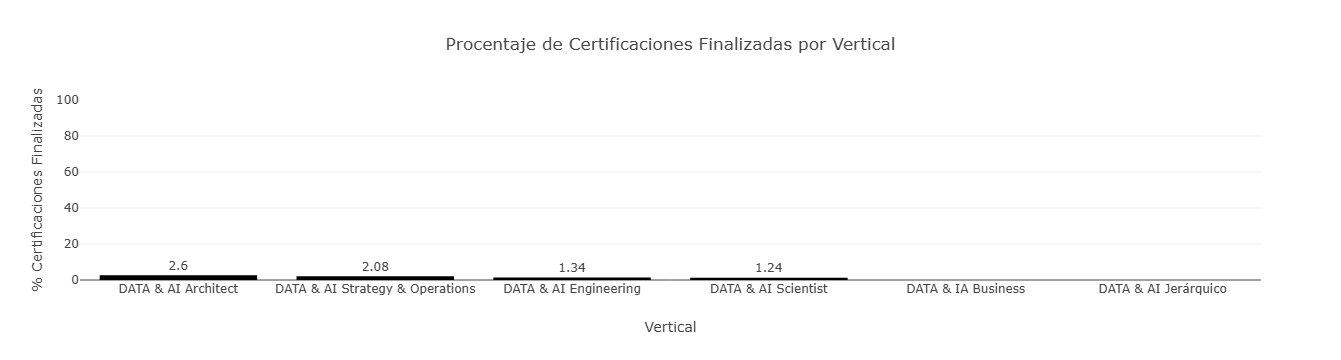

In [102]:
fig = px.bar(data_frame = df_resultado,
             x          = "Vertical",
             y          = "Porcentaje Certificaciones Realizadas",
             range_y    = [0, 100],
             text_auto  = True,
             title      = "Procentaje de Certificaciones Finalizadas por Vertical")

fig.update_layout(xaxis = dict(title = dict(text = "Vertical")),
                  yaxis = dict(title = dict(text = "% Certificaciones Finalizadas")))

fig.show()

# Segunda Gráfica

In [103]:
df = pd.merge(left = df_dicts["Trabajadores"].explode("Nivel").drop("id", axis = 1),
              right = df_dicts["Roles"][["id", "Nivel de carrera MAPFRE"]],
              left_on = "Nivel",
              right_on = "id")

df = df[["Certificaciones", "Certificaciones (from Rol que le corresponde)", "Certificaciones faltantes para el rol (INFORME)", "Nivel de carrera MAPFRE"]]

puestos_orden = ["TÉCNICO AVANZADO",
                 "TÉCNICO SENIOR",
                 "ESPECIALISTA",
                 "EXPERTO",
                 "CONSULTOR",
                 "RESPONSABLE",
                 "JEFE",
                 "SUBDIRECTOR",
                 "DIRECTOR"]

df["Nivel de carrera MAPFRE"] = pd.Categorical(df["Nivel de carrera MAPFRE"], categories = puestos_orden, ordered = True)
df = df.sort_values("Nivel de carrera MAPFRE")

df = df.reset_index(drop = True)

df["Certificaciones Totales"] = df["Certificaciones"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Totales por Rol"] = df["Certificaciones (from Rol que le corresponde)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Certificaciones Faltantes"] = df["Certificaciones faltantes para el rol (INFORME)"].apply(lambda x : len(x) if type(x) == list else 0)

df["Porcentaje Certificaciones Faltantes"] = np.round(df["Certificaciones Faltantes"] / df["Certificaciones Totales por Rol"] * 100, 2)

df_resultado = df.groupby(by = ["Nivel de carrera MAPFRE"], as_index = False).agg({"Porcentaje Certificaciones Faltantes" : "mean"})

df_resultado["Porcentaje Certificaciones Faltantes"] = df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)
df_resultado["Porcentaje Certificaciones Realizadas"] = 100 - df_resultado["Porcentaje Certificaciones Faltantes"].clip(lower = 0, upper = 100)

df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]] = df_resultado[["Porcentaje Certificaciones Faltantes", "Porcentaje Certificaciones Realizadas"]].round(decimals = 2)

# df_resultado = df_resultado.sort_values("Porcentaje Certificaciones Faltantes")

C:\Users\danie\AppData\Local\Temp\ipykernel_19492\667183489.py:31: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



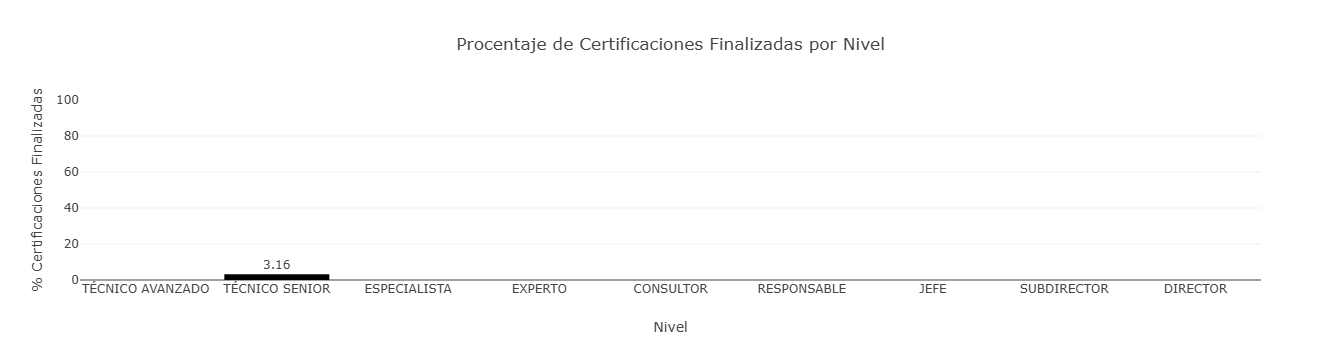

In [105]:
fig = px.bar(data_frame = df_resultado,
             x          = "Nivel de carrera MAPFRE",
             y          = "Porcentaje Certificaciones Realizadas",
             range_y    = [0, 100],
             text_auto  = True,
             title      = "Procentaje de Certificaciones Finalizadas por Nivel")

fig.update_layout(xaxis = {"title" : {"text" : "Nivel"}},
                  yaxis = {"title" : {"text" : "% Certificaciones Finalizadas"}})

fig.show()

# Tercera Gráfica